In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import graphtools as gt
import phate
import magic
import scprep
import cmocean
import sklearn
import scipy
import seaborn as sns
import meld
sc.settings.set_figure_params(dpi=500, dpi_save=1000, figsize=(5,5), facecolor='white')
sc.settings.verbosity = 3  

In [2]:
# set output directory
fig_dir = "/dfs7/swaruplab/smorabit/collab/woodlab/cocaine_mouse_2021/Nurr2c_vs_GFP/figures/"
data_dir = "/dfs7/swaruplab/smorabit/collab/woodlab/cocaine_mouse_2021/Nurr2c_vs_GFP/data/"

sc.settings.figdir = fig_dir

In [3]:
# load processed data
adata = sc.read_h5ad('{}harmony_annotated_integration.h5ad'.format(data_dir))

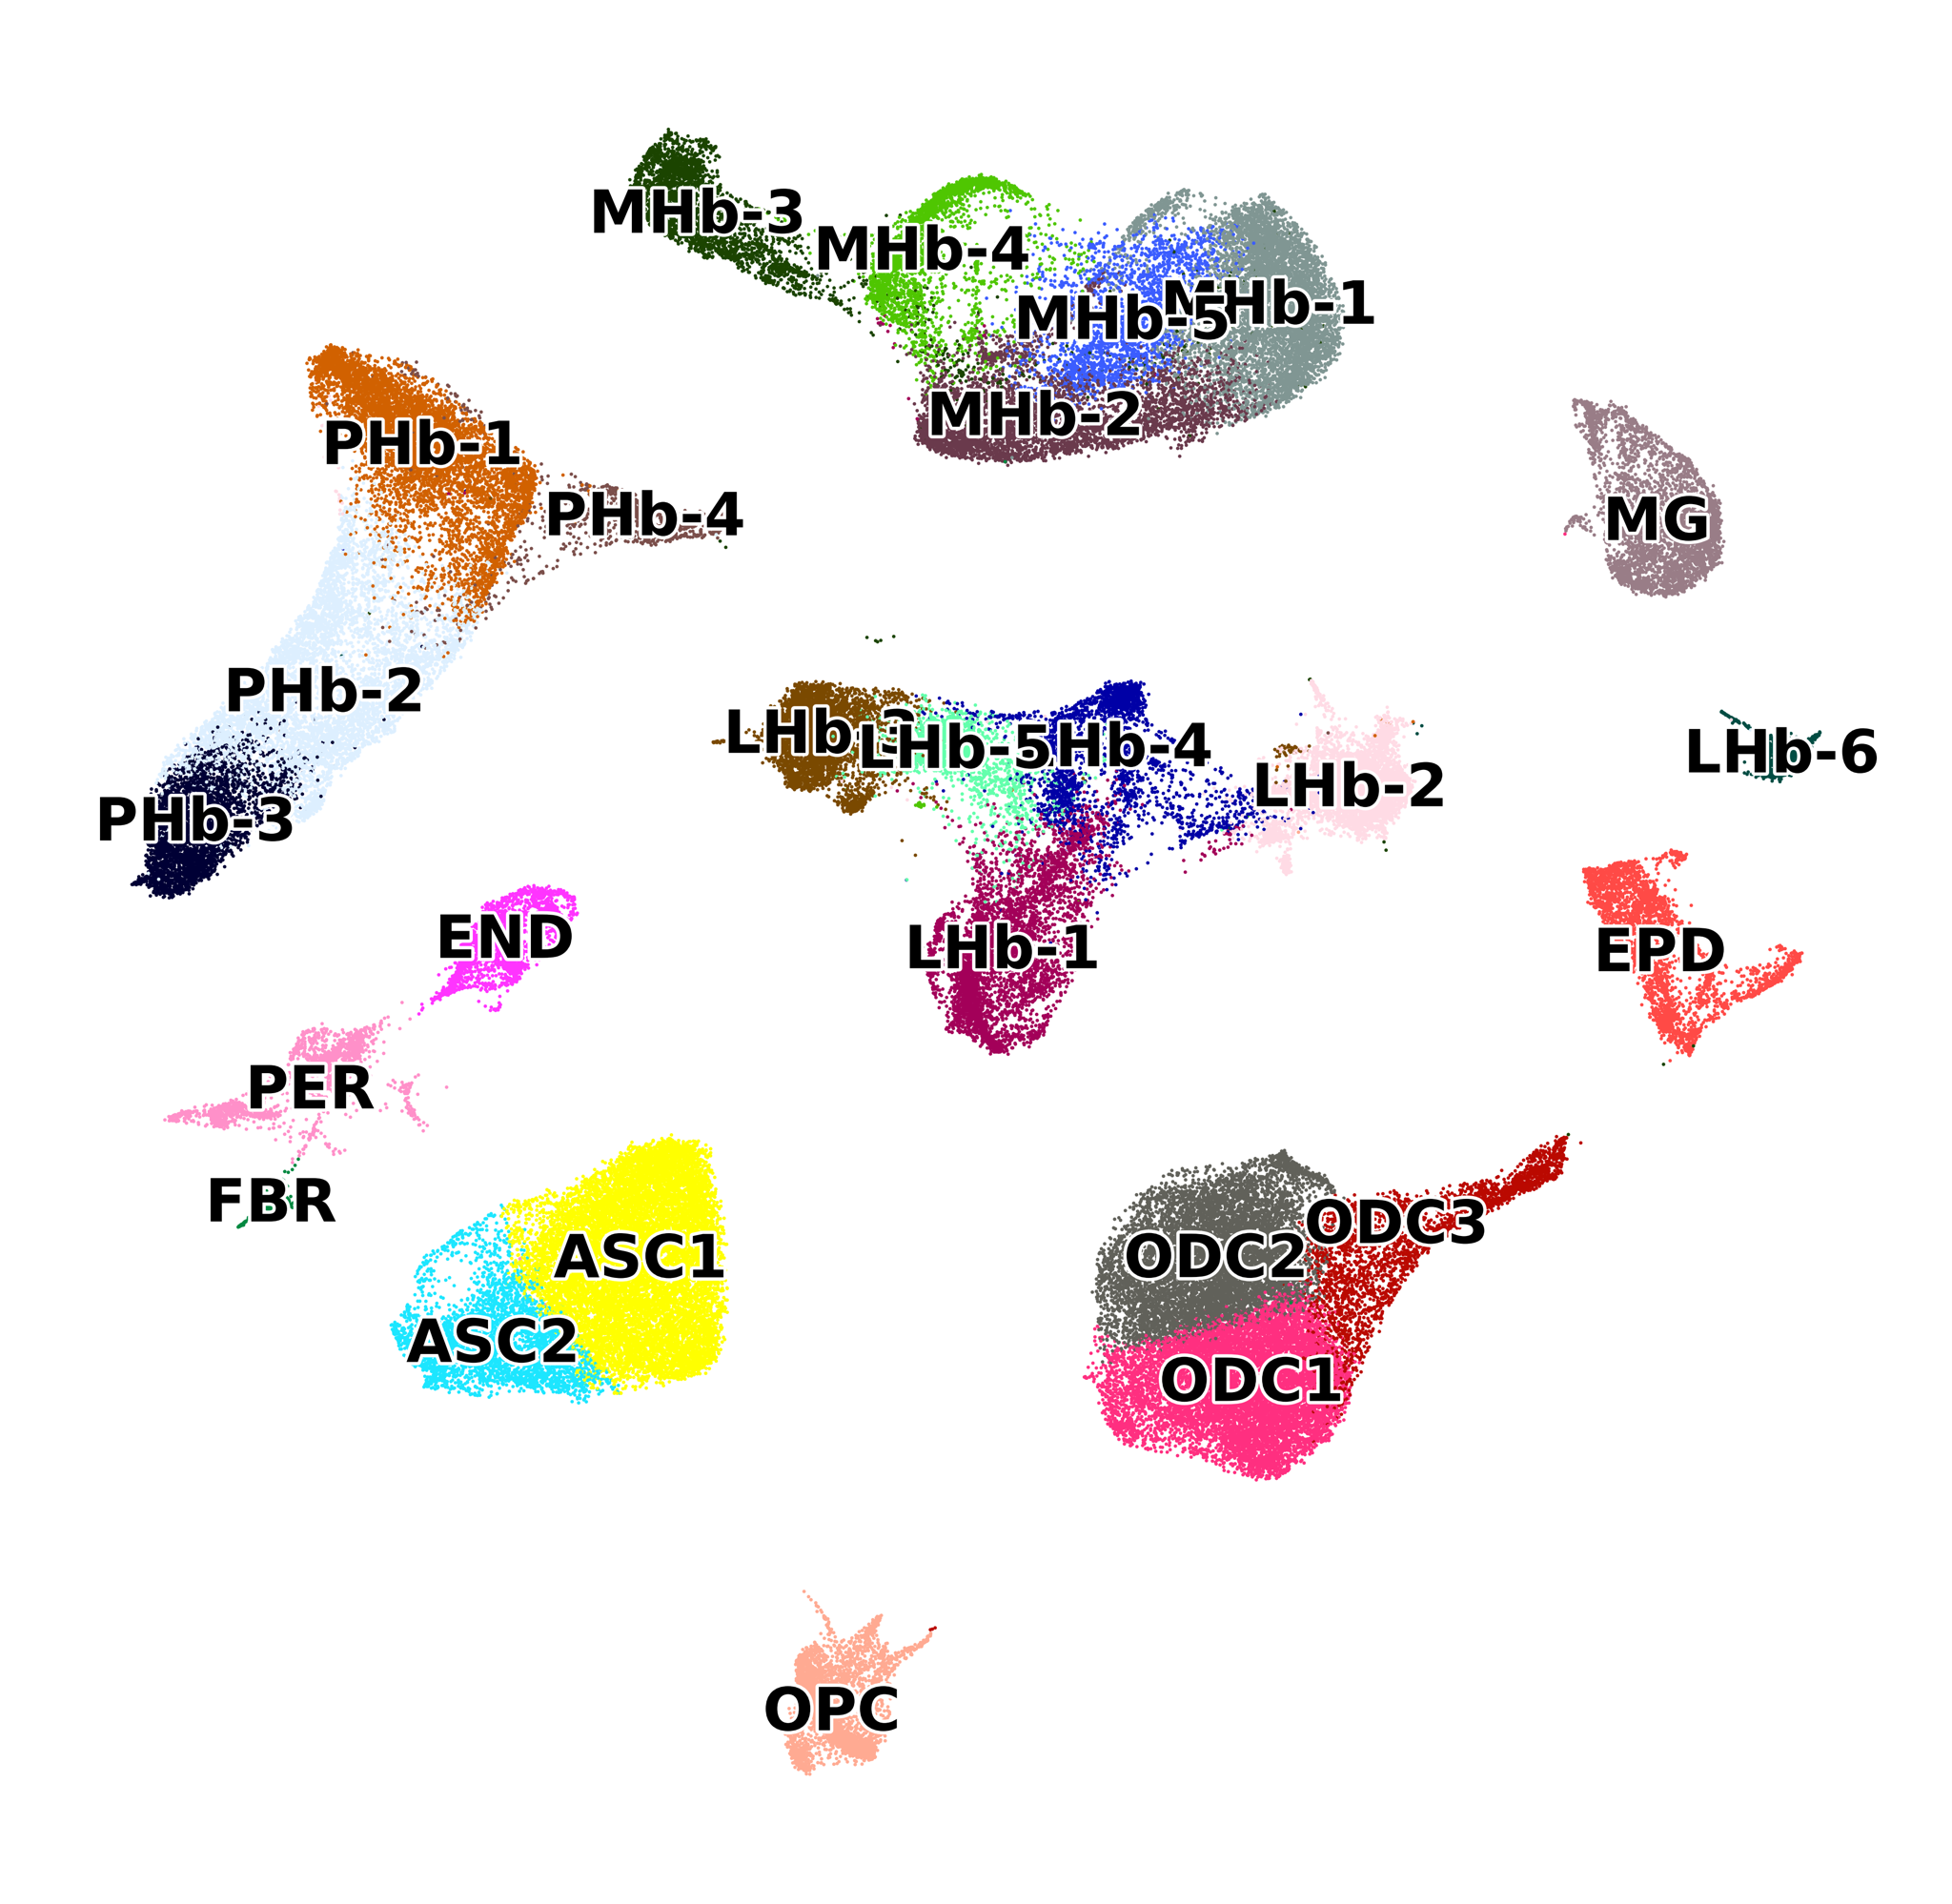

In [4]:
# plot UMAP to test that it loaded correctly:
sc.pl.umap(adata, color=['annotation'],frameon=False, legend_loc='on data', legend_fontoutline=1, legend_fontsize=9, add_outline=False, title='')


## Run MELD (Behavior)

In [7]:
# subset anndata by Behavior only

adata.obs.Group.value_counts()

adata = adata[adata.obs.Group.isin(['Nurr2c', 'GFP'])].copy()
adata.shape

(52108, 32285)

In [8]:
adata.obs['Condition_Sample'] = adata.obs[['Group', 'Sample']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)


In [9]:
benchmarker = meld.Benchmarker()

from joblib import Parallel, delayed

def simulate_pdf_calculate_likelihood(benchmarker, seed, beta):
    benchmarker.set_seed(seed)
    benchmarker.generate_ground_truth_pdf()
    
    benchmarker.generate_sample_labels()
    benchmarker.calculate_MELD_likelihood(beta=beta)
    MELD_mse = benchmarker.calculate_mse(benchmarker.expt_likelihood)
    return MELD_mse, seed, beta, benchmarker.graph.knn


In [10]:
benchmarker.fit_phate(adata.obsm['X_pca_harmony']);

Calculating PHATE...
  Running PHATE on 52108 observations and 50 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 83.29 seconds.
    Calculating affinities...
    Calculated affinities in 0.88 seconds.
  Calculated graph and diffusion operator in 84.21 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 5.60 seconds.
    Calculating KMeans...
    Calculated KMeans in 5.97 seconds.
  Calculated landmark operator in 13.12 seconds.
  Calculating optimal t...
    Automatically selected t = 18
  Calculated optimal t in 1.26 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.37 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 26.36 seconds.
Calculated PHATE in 125.34 seconds.


In [11]:
knn_range = np.arange(1,25)
beta_range = np.arange(1,200)

In [ ]:
results = []

with Parallel(n_jobs=36) as p:
    for knn in knn_range:
        # doing this outside the parallel loop because building the graph takes the longest
        benchmarker.fit_graph(adata.X, knn=knn)
        print(knn)
        curr_results = p(delayed(simulate_pdf_calculate_likelihood)(benchmarker, seed, beta) \
                                       for seed in range(25) for beta in beta_range)
        curr_results = pd.DataFrame(curr_results, columns = ['MSE', 'seed', 'beta', 'knn'])
        results.append(curr_results)

results = pd.concat(results, axis=0)

1
2
3
7
8
9


In [31]:
print('aa')

aa


In [16]:
results.to_csv('{}meld_benchmarking_behavior.csv'.format(data_dir))

In [17]:
# We want to take the average of each set of random seeds for each combination of beta and knn values
results_wide = results.groupby(['beta', 'knn']).mean().sort_values(by='MSE').reset_index()

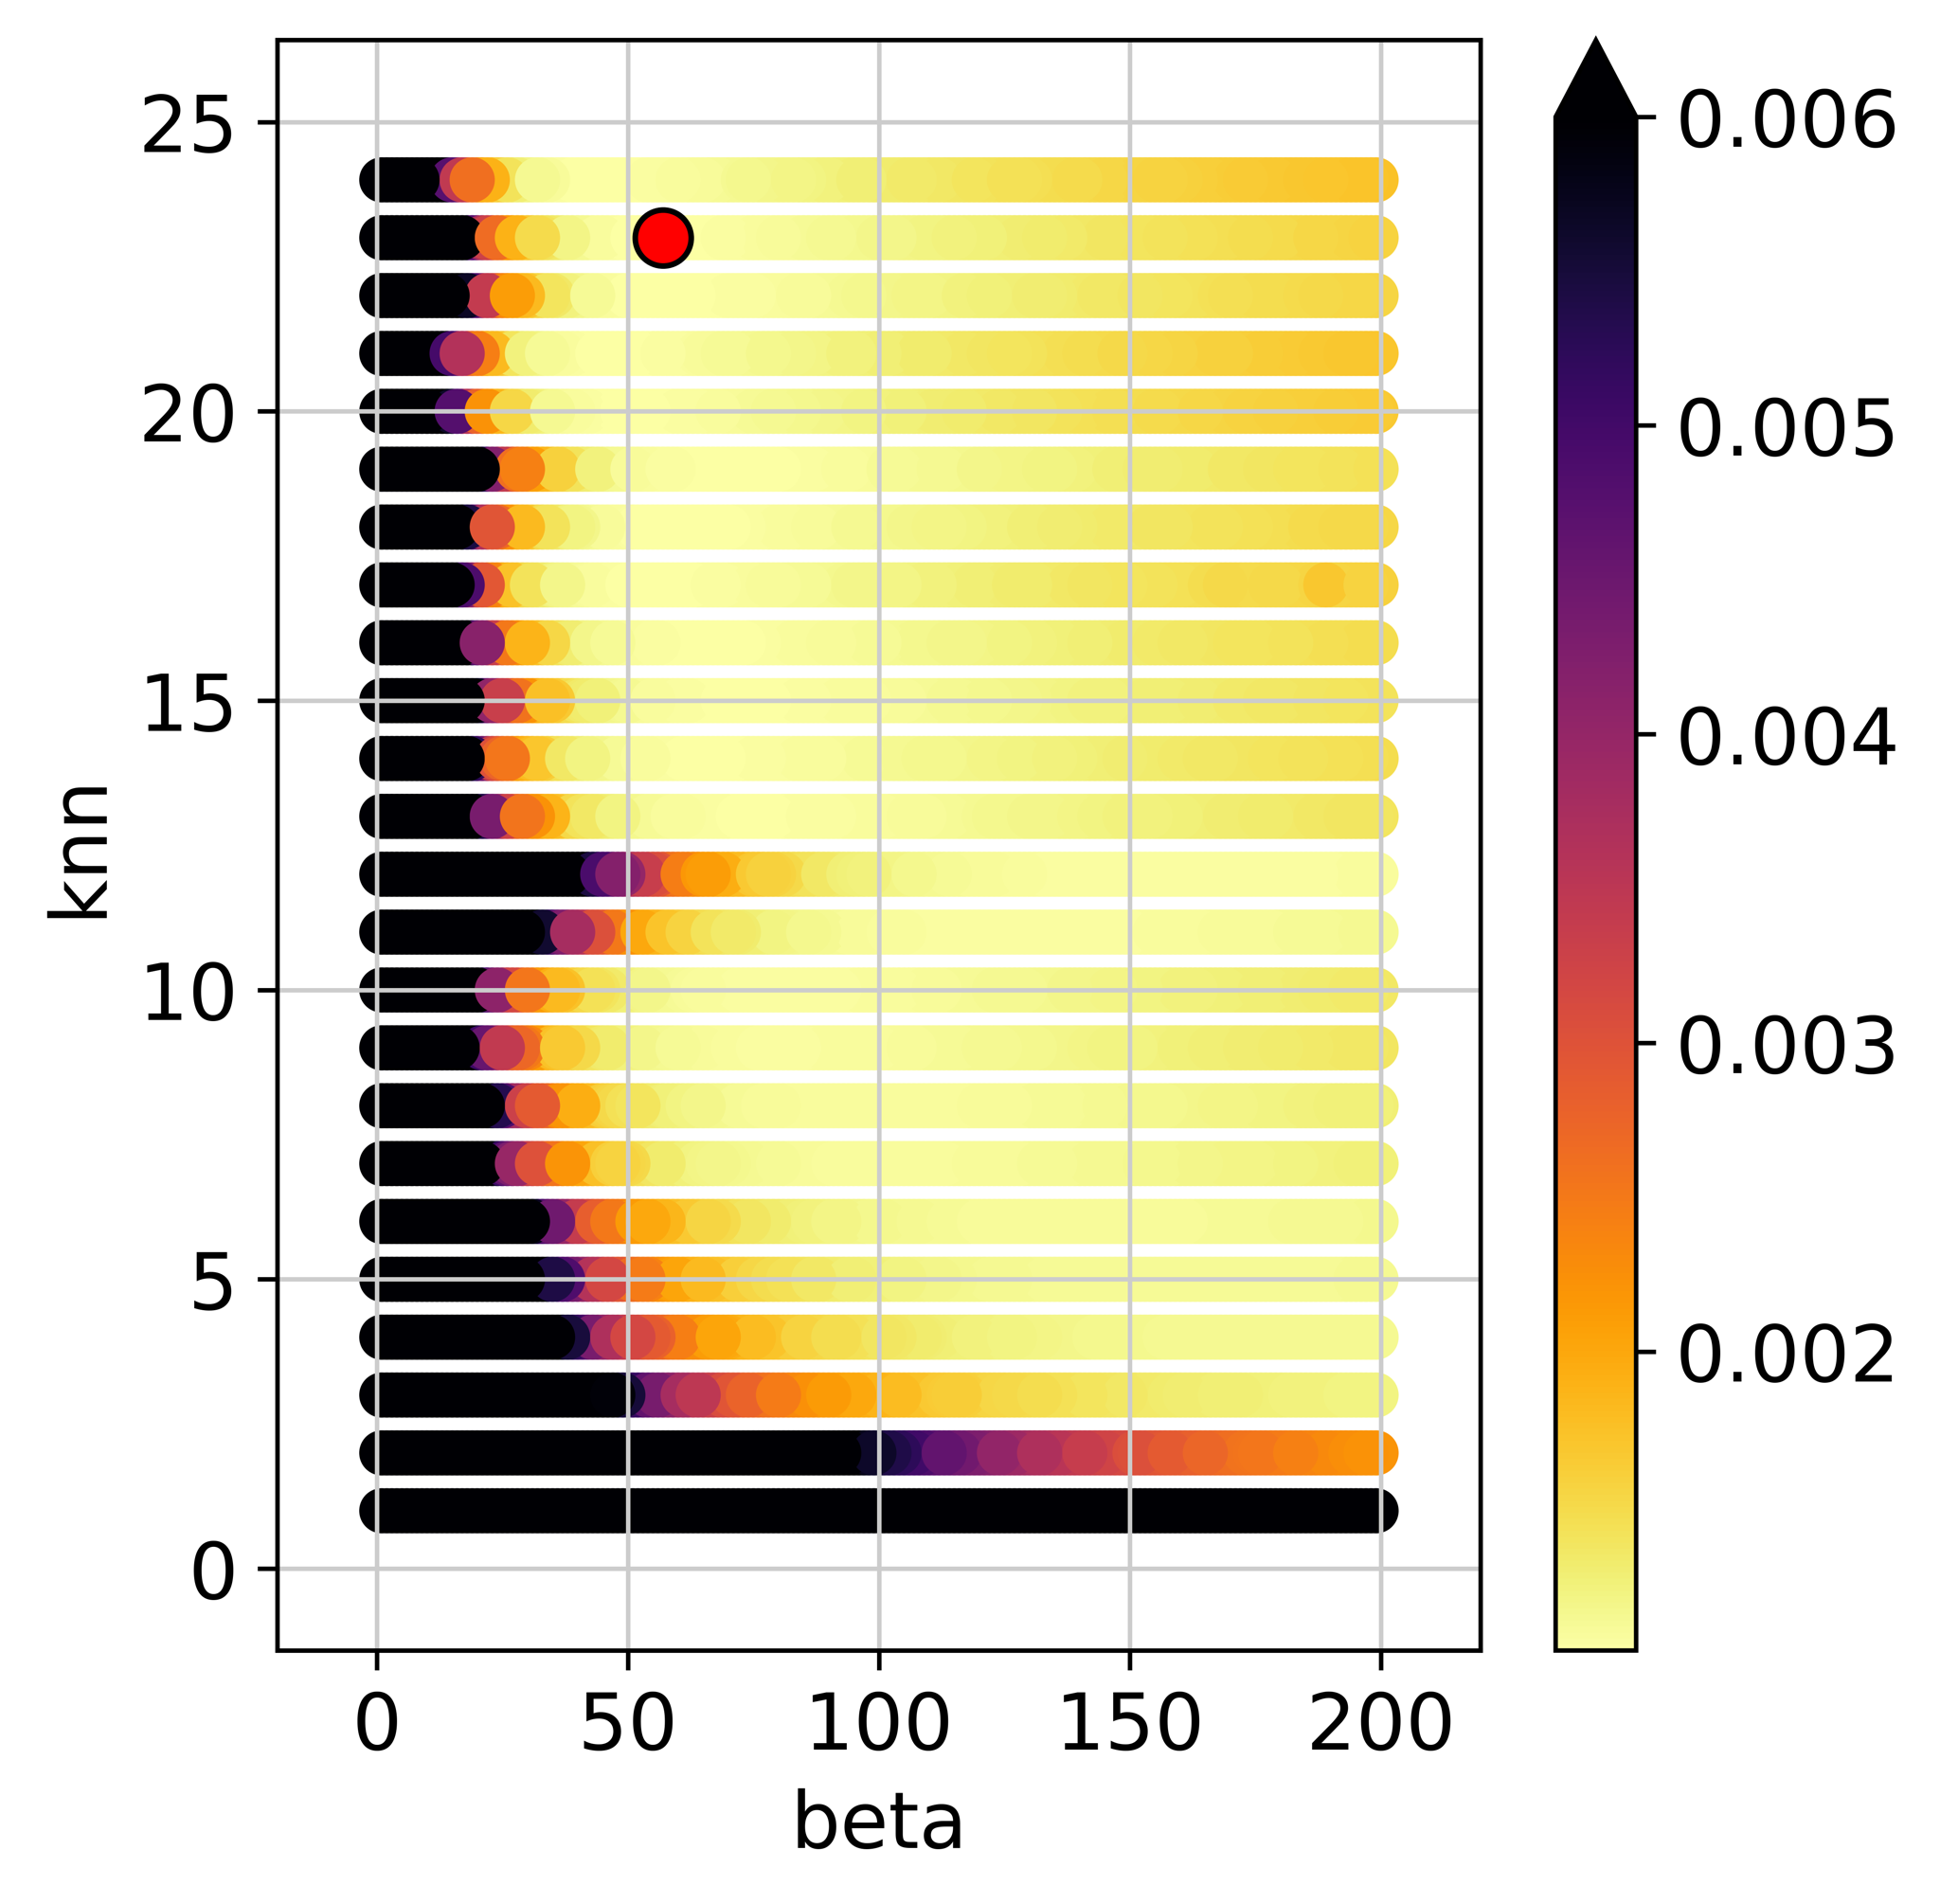

In [18]:
ax = scprep.plot.scatter(results_wide['beta'], results_wide['knn'], 
                         s=50, c=results_wide['MSE'], vmax=0.006, cmap='inferno_r')

# Highlight the top performing combination with a large red dot
top_result = results_wide.sort_values('MSE').iloc[0]
ax.scatter(top_result['beta'], top_result['knn'], c='r', s=100, linewidth=1, edgecolor='k')

## Run MELD with best parameters

In [19]:
G = gt.Graph(adata.obsm['X_pca_harmony'], knn=int(top_result['knn']), use_pygsp=True)


In [20]:
meld_op = meld.MELD(beta=top_result['beta'])
sample_densities = meld_op.fit_transform(G, sample_labels=adata.obs.Condition_Sample)

Building graph on 52108 samples and 50 features.


In [21]:
sample_densities.head()

,GFP_Sample-13,GFP_Sample-4,GFP_Sample-5,GFP_Sample-8,GFP_Sample-9,Nurr2c_Sample-1,Nurr2c_Sample-11,Nurr2c_Sample-14,Nurr2c_Sample-16,Nurr2c_Sample-2,Nurr2c_Sample-3
0,0.000037,0.000008,0.000042,0.000018,5.913633e-07,0.000025,0.000019,0.000003,0.000035,0.000013,0.000006
1,0.000010,0.000006,0.000009,0.000012,5.925111e-05,0.000019,0.000034,0.000014,0.000011,0.000017,0.000016
2,0.000047,0.000008,0.000032,0.000009,5.385793e-07,0.000031,0.000023,0.000004,0.000038,0.000012,0.000006
3,0.000007,0.000012,0.000015,0.000011,4.537536e-06,0.000032,0.000021,0.000057,0.000010,0.000011,0.000028
4,0.000010,0.000010,0.000017,0.000014,1.364665e-06,0.000031,0.000020,0.000064,0.000005,0.000021,0.000017


In [22]:
replicates = np.unique(adata.obs['Condition_Sample'])
sample_likelihoods = sample_densities.copy()
for rep in replicates:
    curr_cols = sample_densities.columns[[col.startswith(rep) for col in sample_densities.columns]]
    scaler = sklearn.preprocessing.MinMaxScaler()
    sample_likelihoods[curr_cols] = scaler.fit_transform(sample_densities[curr_cols])



sample_likelihoods

,GFP_Sample-13,GFP_Sample-4,GFP_Sample-5,GFP_Sample-8,GFP_Sample-9,Nurr2c_Sample-1,Nurr2c_Sample-11,Nurr2c_Sample-14,Nurr2c_Sample-16,Nurr2c_Sample-2,Nurr2c_Sample-3
0,0.196473,0.132307,0.652540,0.237963,0.001875,0.218115,0.176809,0.018215,0.400952,0.178891,0.062407
1,0.054291,0.096943,0.138486,0.160649,0.242993,0.164387,0.328659,0.083663,0.128825,0.238509,0.158228
2,0.253278,0.127435,0.502241,0.119526,0.001658,0.264188,0.216927,0.021731,0.430207,0.172998,0.058548
3,0.037777,0.200570,0.239565,0.147085,0.018095,0.272791,0.195321,0.356223,0.111950,0.152223,0.277258
4,0.053778,0.170619,0.270036,0.181338,0.005053,0.267850,0.191082,0.396140,0.061827,0.297082,0.167109
...,...,...,...,...,...,...,...,...,...,...,...
52103,0.040401,0.357703,0.306301,0.249513,0.052706,0.136722,0.175328,0.014137,0.382071,0.160773,0.377293
52104,0.179677,0.198644,0.208461,0.190688,0.148042,0.064597,0.211696,0.147075,0.113851,0.272211,0.291435
52105,0.010094,0.226765,0.157517,0.372422,0.184401,0.161859,0.243354,0.016812,0.123244,0.429593,0.147071
52106,0.128860,0.301703,0.247035,0.154828,0.056368,0.211191,0.095422,0.172352,0.539214,0.184735,0.134652


In [23]:
condition_cols = sample_likelihoods.columns[[col.startswith("Nurr2c") for col in sample_likelihoods.columns]]
mean_likelihoods = sample_likelihoods[condition_cols].mean(axis=1).values
adata.obs['Nurr2c_likelihood'] = scaler.fit_transform(mean_likelihoods.reshape(-1,1))


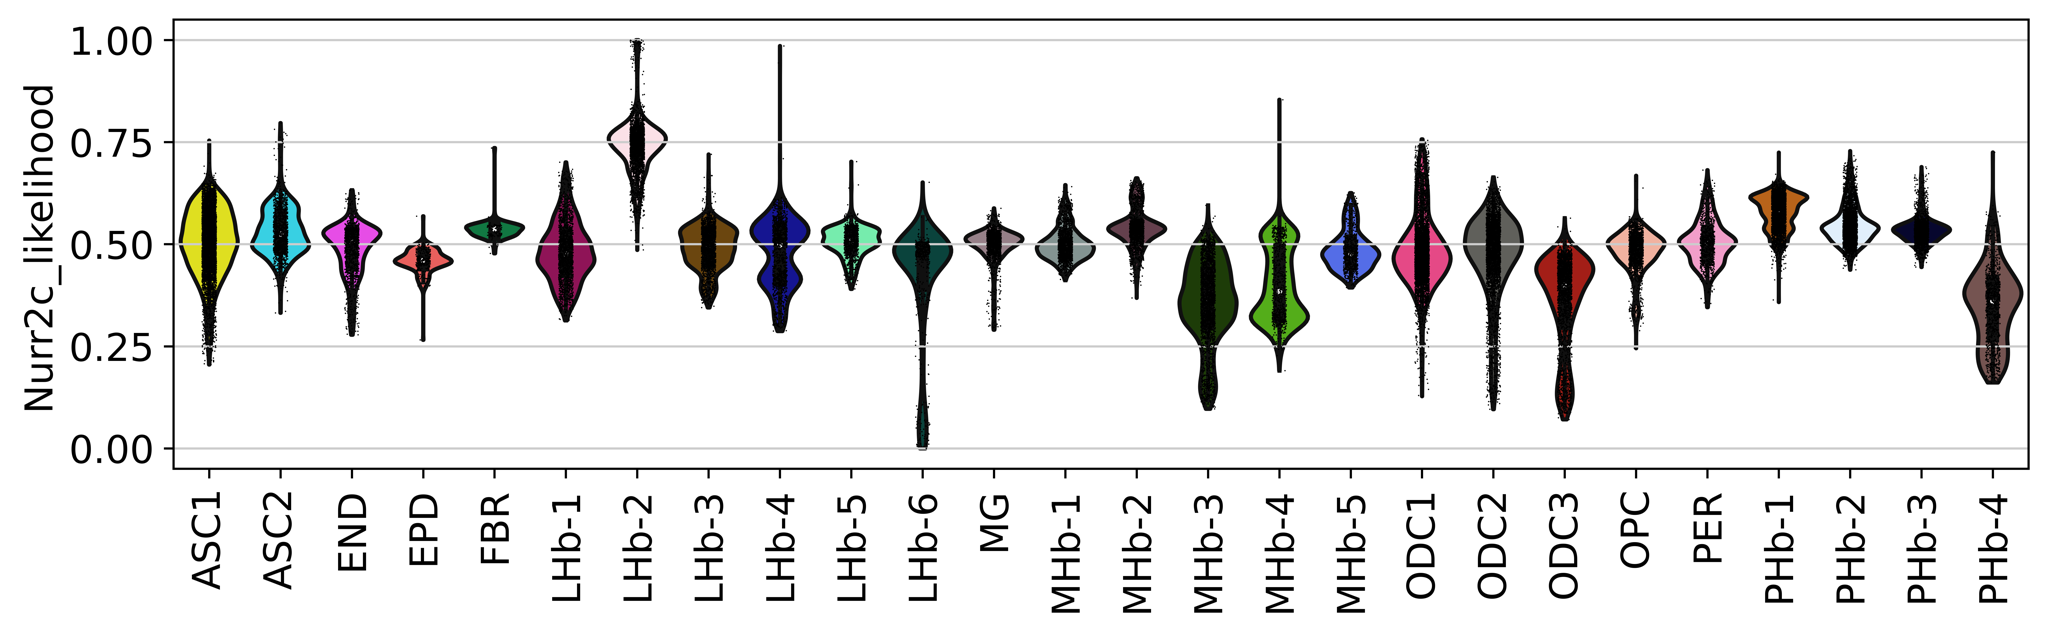

In [24]:
sc.settings.set_figure_params(dpi=500, dpi_save=1000, figsize=(10,3), facecolor='white')
sc.pl.violin(adata,['Nurr2c_likelihood'], inner='box', size=0.5,  groupby='annotation', multi_panel=False, rotation=90)


In [25]:
adata.obs[['barcode', 'Nurr2c_likelihood']].to_csv('{}MELD_Nurr2c_likelihood_behavior.csv'.format(data_dir))

## Using Condition instead of Condition_Sample

In [26]:
meld_op = meld.MELD(beta=top_result['beta'])
sample_densities = meld_op.fit_transform(G, sample_labels=adata.obs.Group)

Building graph on 52108 samples and 50 features.


In [27]:
replicates = np.unique(adata.obs['Group'])
sample_likelihoods = sample_densities.copy()
for rep in replicates:
    curr_cols = sample_densities.columns[[col.startswith(rep) for col in sample_densities.columns]]
    scaler = sklearn.preprocessing.MinMaxScaler()
    sample_likelihoods[curr_cols] = scaler.fit_transform(sample_densities[curr_cols])



sample_likelihoods

,GFP,Nurr2c
0,0.497574,0.502426
1,0.412589,0.587411
2,0.418603,0.581397
3,0.240476,0.759524
4,0.256196,0.743804
...,...,...
52103,0.388846,0.611154
52104,0.458938,0.541062
52105,0.465728,0.534272
52106,0.364212,0.635788


In [28]:
adata.obs['Nurr2c_likelihood'] = sample_likelihoods['Nurr2c'].tolist()


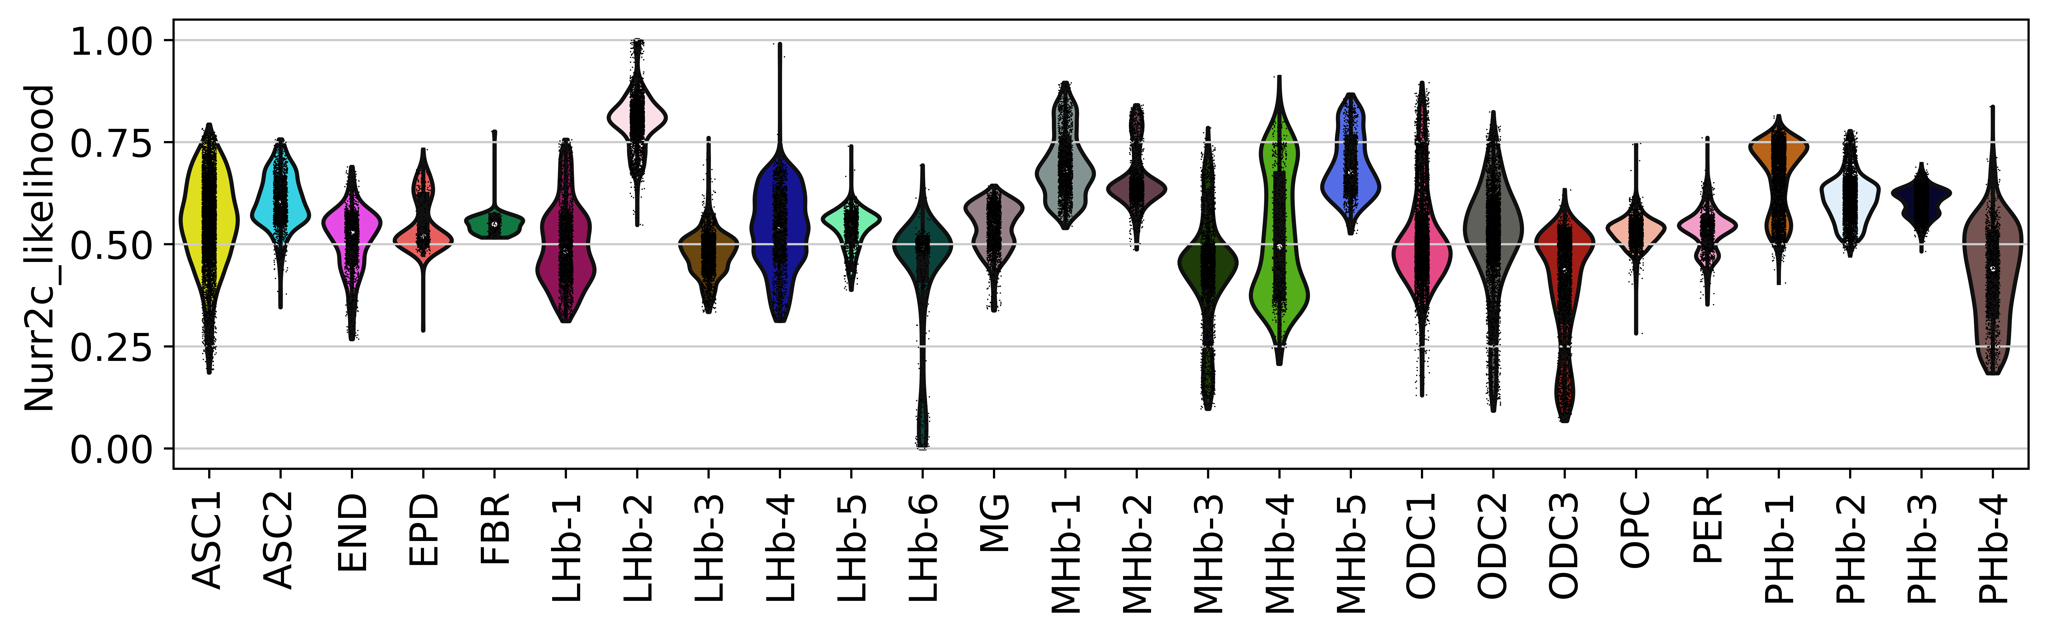

In [29]:
sc.settings.set_figure_params(dpi=500, dpi_save=1000, figsize=(10,3), facecolor='white')
sc.pl.violin(adata,['Nurr2c_likelihood'], inner='box', size=0.5,  groupby='annotation', multi_panel=False, rotation=90)


## Save the results

In [30]:
adata.obs[['barcode', 'Nurr2c_likelihood']].to_csv('{}MELD_Nurr2c_likelihood_behavior.csv'.format(data_dir))

## Run the analysis on the Naive dataset

In [33]:
# load processed data
adata = sc.read_h5ad('{}harmony_annotated_integration.h5ad'.format(data_dir))

In [34]:
adata = adata[adata.obs.Group.isin(['NN', 'NGFP'])].copy()


In [36]:
adata.obs['Condition_Sample'] = adata.obs[['Group', 'Sample']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)


In [35]:
G = gt.Graph(adata.obsm['X_pca_harmony'], knn=int(top_result['knn']), use_pygsp=True)


In [37]:
meld_op = meld.MELD(beta=top_result['beta'])
sample_densities = meld_op.fit_transform(G, sample_labels=adata.obs.Group)

Building graph on 57773 samples and 50 features.


In [38]:
replicates = np.unique(adata.obs['Group'])
sample_likelihoods = sample_densities.copy()
for rep in replicates:
    curr_cols = sample_densities.columns[[col.startswith(rep) for col in sample_densities.columns]]
    scaler = sklearn.preprocessing.MinMaxScaler()
    sample_likelihoods[curr_cols] = scaler.fit_transform(sample_densities[curr_cols])



sample_likelihoods

,NGFP,NN
0,0.542252,0.457748
1,0.421688,0.578312
2,0.100378,0.899622
3,0.169144,0.830856
4,0.430868,0.569132
...,...,...
57768,0.355969,0.644031
57769,0.393733,0.606267
57770,0.358431,0.641569
57771,0.360686,0.639314


In [40]:
adata.obs['Nurr2c_likelihood'] = sample_likelihoods['NN'].tolist()


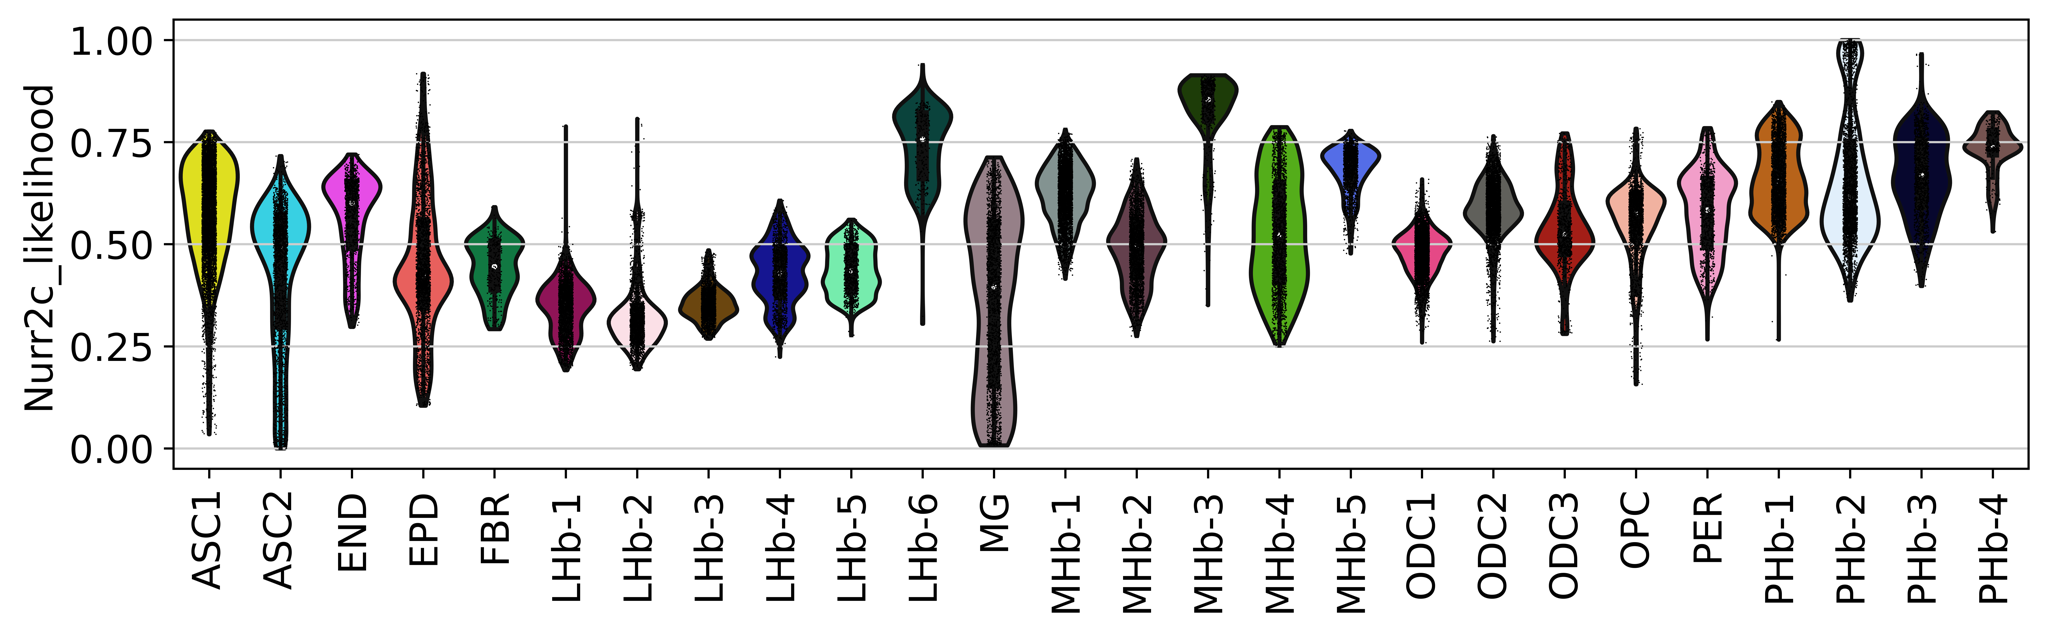

In [42]:
sc.settings.set_figure_params(dpi=500, dpi_save=1000, figsize=(10,3), facecolor='white')
sc.pl.violin(adata,['Nurr2c_likelihood'], inner='box', size=0.5,  groupby='annotation', multi_panel=False, rotation=90)
